# Solar sail (maximum orbit change)

Maximize the dispacement of the solar sail in the tangent manifold of its orbital elements over one orbit:

$$ \delta I ' = \mathbf{G} \, u, $$
$$ \delta I = \varepsilon \int_{M_0}^{M_f} \mathbf{G}(I,M) \, u \ \textrm{d} M, \quad u \in \mathcal{U}$$
$$ \delta I (M_0) = 0, \quad \delta I (M_f) \parallel \mathbf{b}, $$
$$ \left( \delta I (M_f) \, | \, \mathbf{b} \right) \longrightarrow \max, $$
$$ M_0 = 0; M_f = 2 \pi $$

Fixed initial Keplerian orbit and direction of the displacement $\mathbf{b}$. 

[Thumbnail](figs/kepler-py.png)

## Initializations

In [1]:
import numpy as np
import scipy
from scipy.integrate import ode
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [15, 15]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower
from mpl_toolkits.mplot3d import Axes3D
import time
from nutopy import nle
from nutopy import tools
from nutopy import ocp
from nutopy import path
from scipy.linalg import null_space
from gve import *
from gvef import *
from os import system

# Definition of optical parameters 
rho     = 0.88         # Specular reflection coefficient
a       = 1. - rho    # Absorption coefficient
s       = 0.94        # Diffuse reflection coefficient 
eps_f   = 0.05        # Emissivity front coeff 0.05
eps_b   = 0.55        # Emissivity back coeff 0.55
Bf      = 0.79        # Front Lambertian coeff 0.79
Bb      = 0.55        # Back Lambertian coeff 0.55
eps     = (Bf * eps_f - Bb * eps_b) / (eps_b + eps_f) 
#opt_p   = np.array([rho, s, eps_f, eps_b, Bf, Bb, eps])
b       = np.array([1. - rho * s, 2. * rho * s, Bf * rho * (1. - s) + (1. - rho) * eps ])

# Parameters of the problem
cont    = 1.          # 0 for triangular cone, 1 for real drop 
mu      = 1.


def deg2rad(x):
    y = x * np.pi / 180.
    return y

def rad2deg(x):
    y = x * 180. / np.pi
    return y


#""" # SIMPLE CASE WITHOUT STRUCTURE CHANGE rho = 0.88
#pI         = np.array([ -0.3165,   -1.2780,   -0.0747,   -0.3282,    1.0000])
#M1_guess   = 1.1729
#M2_guess   = 4.9515
#I1_guess   = np.array([ -0.2916,    0.0532,    0.0271,   -0.0173,    0.0696])
#I2_guess   = np.array([ -0.2899,    0.0551,    0.0266,   -0.0217,    0.0710])
#I          = np.array([deg2rad(10), deg2rad(20), deg2rad(30), 1, 0.5])  
#M_guess    = np.array([M1_guess, M2_guess])
#d          = np.array([ 0.,  0.,  0.,  0.,  1.]) 
#"""

# CASE WITH STRUCTURE CHANGE

I            = np.array([deg2rad(10), deg2rad(50), deg2rad(30), 1, 0.1]) 
pI           = np.array([ -0.0837,    1.0000,   -0.0052,    0.0398,    0.0852 ])
M1_guess     = 0.7086
M2_guess     = 4.3302
M3_guess     = 4.7962
M4_guess     = 5.2500
I1_guess     = np.array([ -0.0013,   -0.0002,    0.0251,    0.0027,    0.0012])
I2_guess     = np.array([ 0.0136,    0.4053,   -0.3069,    0.0473,   0.0656])
I3_guess     = np.array([ 0.0148,    0.4054,   -0.3289,    0.0498,    0.0626])
I4_guess     = np.array([ 0.0000,    0.4134,   -0.0002,    0.0001,    0.0000])
d            = np.array([ 0.,  1.,  0.,  0.,  0.]) 


z          = np.hstack((pI, M1_guess, M2_guess, M3_guess, M4_guess, I1_guess, I2_guess, I3_guess, I4_guess))
z_auto     = np.hstack((pI))
sDir       = np.array([0., 0., -1.])


# Initial state

I0      = np.array([0., 0., 0., 0., 0])                                                     # delta I (0)
M0      = 0
Mf      = 2*np.pi

# Real cone force definition
cBeta   = (- b[0] * b[2]  - 2. * b[1] * b[2] + \
             np.sqrt(b[0] ** 2 * b[2] ** 2 - 4. * b[0] * b[2] ** 2 * b[1] + 8. * b[0] ** 2 * b[1] ** 2 + 4. * b[1] ** 3 * b[0])) / \
             (4. * b[0] * b[1] + 2. * b[1] ** 2);
sBeta 	= np.sqrt(1 - cBeta ** 2);
fs    	= b[0] * cBeta + (b[1] * cBeta ** 2 + b[2] * cBeta) * cBeta;
fperp 	= (b[1] * cBeta ** 2 + b[2] * cBeta) * sBeta;
fCone 	= np.array([fs, fperp])


pars    = np.hstack((mu, I, fCone, b))

# Orthogonal vector family
d_orth  = scipy.linalg.null_space([d])                                                                     # Orthogonal space of b
d_orth  = d_orth.transpose()

In [2]:
#!pygmentize hfun.f90		

## Hamiltonian

In [3]:
!python -m numpy.f2py -c hfun.f90     hfun.pyf     -m hfun     > /dev/null 2>&1
!python -m numpy.f2py -c hfun_d.f90   hfun_d.pyf   -m hfun_d   > /dev/null 2>&1
!python -m numpy.f2py -c hfun_d_d.f90 hfun_d_d.pyf -m hfun_d_d > /dev/null 2>&1

In [4]:
from hfun     import hfun     
from hfun_d   import hfun_d   
from hfun_d_d import hfun_d_d 

hfun_u      = lambda M, q, p, pars, cont                                           : hfun.hfun_u(M, q, p, pars, cont)
ufun        = lambda M, q, p, cont                                                 : hfun.control(M, q, p, pars, cont) 
#control     = lambda M, q, p, pars, cont                                           : hfun.control(M, q, p, pars, cont) 
dhfun_u     = lambda M, dM, q, dq, p, dp, pars, cont, dcont                        : hfun_d.hfun_u_d(M, dM, q, dq, p, dp, pars, cont, dcont)
d2hfun_u    = lambda M, dM, d2M, q, dq, d2q, p, dp, d2p, pars, cont, dcont, d2cont : hfun_d_d.hfun_u_d_d(M, dM, d2M, q, dq, d2q, p, dp, d2p, pars, cont, dcont, d2cont)

In [5]:
def dhfun_0(M, dM, q, dq, p, dp, pars, cont, dcont):
    h = 0.0
    dh  = 0.0
    return h, dh

def d2hfun_0(M, dM, d2M, q, dq, d2q, p, dp, d2p, pars, cont, dcont, d2cont):
    h   = 0.0
    dh  = 0.0
    d2h = 0.0
    return h, dh, d2h

def hfun_0(M, q, p, pars, cont):
    h = 0.0
    return h

In [6]:
hfun_u      = tools.tensorize(dhfun_u, d2hfun_u, tvars=(1, 2, 3, 5), full=True)(hfun_u)
hfun_0      = tools.tensorize(dhfun_0, d2hfun_0, tvars=(1, 2, 3, 5), full=True)(hfun_0)
ufun        = tools.vectorize(vvars=(1,2,3))(ufun)
#control     = tools.vectorize(vvars=(1,2,3))(control)
Hu          = ocp.Hamiltonian(hfun_u)
H0          = ocp.Hamiltonian(hfun_0)
fu          = ocp.Flow(Hu)
f0          = ocp.Flow(H0)

## Shooting function

In [7]:
#@tools.tensorize(dshoot, tvars=(1,), full=True)
def shoot_zbzbz(z, pars, d, d_orth, cont):
#def shoot(z, pars, d, d_orth, cont, next=False):
    I0 = np.zeros(5)
    M0 = 0.
    Mf = 2. * np.pi 
    pI = z[0 : 5]
    M1 = z[5]
    M2 = z[6]
    M3 = z[7]
    M4 = z[8]
    I1 = z[9 : 14]
    I2 = z[14 : 19]
    I3 = z[19 : 24]
    I4 = z[24 : 29]

    #----------------------------------
    I1sol, pI1 = f0(M0, I0, pI, M1, pars, cont)
    I2sol, pI2 = fu(M1, I1, pI, M2, pars, cont)
    I3sol, pI3 = f0(M2, I2, pI, M3, pars, cont)
    I4sol, pI4 = fu(M3, I3, pI, M4, pars, cont)
    If, pIf    = f0(M4, I4, pI, Mf, pars, cont)

    #----------------------------------
    s        = np.zeros(29)
    s[0]     = pIf[0] * d[0] + pIf[1] * d[1] + pIf[2] * d[2] + pIf[3] * d[3] + pIf[4] * d[4] - np.linalg.norm(d)**2
    s[1 : 5] = np.dot(d_orth, If)
    s[5]        = Hu(M1, I1, pI, pars, cont)
    s[6]        = Hu(M2, I2, pI, pars, cont)
    s[7]        = Hu(M3, I3, pI, pars, cont)
    s[8]        = Hu(M4, I4, pI, pars, cont)
    s[9 : 14]   = I1 - I1sol 
    s[14 : 19]  = I2 - I2sol
    s[19 : 24]  = I3 - I3sol
    s[24 : 29]  = I4 - I4sol

    # on impose pas la continuité de pI car il est constant
    # il faut imposer la continuité de l'etat deltaI entre les switchs

    #if not next: return s
    #else: return s, (Mf, If, pIf, None)
    return s

#@tools.tensorize(shoot_zbz, tvars=(1,), full=True)
def shoot_zbz(z, pars, d, d_orth, cont):
#def shoot(z, pars, d, d_orth, cont, next=False):
    I0 = np.zeros(5)
    M0 = 0.
    Mf = 2. * np.pi 
    pI = z[0 : 5]
    M1 = z[5]
    M2 = z[6]
    I1 = z[7 : 12]
    I2 = z[12 : 17]

    #----------------------------------
    I1sol, pI1 = f0(M0, I0, pI, M1, pars, cont)
    I2sol, pI2 = fu(M1, I1, pI, M2, pars, cont)
    If, pIf    = f0(M2, I2, pI, Mf, pars, cont)

    #----------------------------------
    s        = np.zeros(17)
    s[0]     = pIf[0] * d[0] + pIf[1] * d[1] + pIf[2] * d[2] + pIf[3] * d[3] + pIf[4] * d[4] - np.linalg.norm(d)**2
    s[1 : 5] = np.dot(d_orth, If)
    s[5]        = Hu(M1, I1, pI, pars, cont)
    s[6]        = Hu(M2, I2, pI, pars, cont)
    s[7 : 12]   = I1 - I1sol 
    s[12 : 17]  = I2 - I2sol

    # on impose pas la continuité de pI car il est constant
    # il faut imposer la continuité de l'etat deltaI entre les switchs

    #if not next: return s
    #else: return s, (Mf, If, pIf, None)
    return s

# Callback
def check_singular_arc(infos):
    #print('    Switching times: t1 = %e, t2 = %e' % (infos.x[0], infos.x[1]))
    t1 = infos.x[0]
    t2 = infos.x[1]
    t3 = infos.x[1]
    t4 = infos.x[1]
    status = 0
    if t4<=t3:
        status = -11 # the second bang has vanished
    return status


In [8]:
@tools.vectorize(vvars =(1,))
def control(M, I, pI, cont):
    sol  = np.array([0., 0., 0.])
    print("we are here")
    if type(M)==float or type(M)==int:
        print("case 1: M is float")
        if Hu(M, I, pI, pars, cont) < 0.:
            sol = np.array([0., 0., 0.])
        else: 
            sol = ufun(M, I, pI, cont)
    else:
        print("case 2: M is vector of", str(np.size(M)))
        for ii in range(np.size(M)):
            if Hu(M[ii], I, pI, pars, cont) < 0.:
                sol = np.vstack((sol, np.array([0., 0., 0.])))
            else: 
                sol = np.vstack((sol, ufun(M[ii], I, pI, cont)))   
        sol = np.delete(sol, 0, 0)
    return sol

# Solve

## MULTIPLE SHOOTING: Simple problem (no structure change) 

In [9]:
dfoo = lambda z, dz, cont: shoot_zbzbz((z, dz), pars, d, d_orth, (cont, 0.)) 
foo = lambda z, cont: shoot_zbzbz(z, pars, d, d_orth, cont)
#foo = tools.tensorize(dfoo, full=True)(foo)
foo = tools.tensorize(dfoo, tvars=(1,), full=True)(foo)

In [10]:
nleopt = nle.Options(SolverMethod='hybrj', Display='on', TolX=1e-8)#, MaxFEval = 1000) 
#et = time.time(); sol = nle.solve(foo, z, df=foo, options=nleopt, args=cont); 
et = time.time(); sol = nle.solve(foo, z, options=nleopt, args=cont); 
et = time.time() - et
print('Elapsed time:', et)
z_sol = sol.x; 

print('z_sol =', z_sol)
print('switch times are: ', z_sol[5:9])
print('foo =', foo(z_sol, cont))
#print('foo =', foo((z_sol, np.zeros(17)), cont))
#print('\n\n\n BEWARE: convergence is faster with finite differences!!! It should not be the case!!! \n\n\n')


     Calls  |f(x)|                 |x|
 
         1  2.245103809255712e+01  8.458754036499702e+00
         2  5.015904191504937e+00  1.264327454786191e+01
         3  1.388325902032013e+02  2.691819210586300e+01
         4  7.547618298628807e+01  1.643694713441474e+01
         5  3.109193015814173e+00  1.251297610713879e+01
         6  1.099251510830584e+01  1.277412795653605e+01
         7  2.578469331658980e+00  1.284964731814349e+01
         8  2.753658653276276e+00  1.346625265772966e+01
         9  2.344701204971913e+00  1.304932226772426e+01
        10  3.024761173806390e+00  1.353755509551367e+01
        11  2.194301733305215e+00  1.324614527833407e+01
        12  4.538374163087010e+00  1.376474186198960e+01
        13  2.463001303795404e+00  1.348562862561565e+01
        14  2.172137008266286e+00  1.310611697125242e+01
        15  1.917901815883603e+00  1.294498100042327e+01
        16  1.836284083845746e+00  1.312682643499466e+01
        17  1.679685971000088e+00  1.263431255

# Plot function

In [11]:
def plotSolutionBSB(z_sol, sDir, cont, nOrb):

    pI         = z_sol[0 : 5]
    M1         = z_sol[5]
    M2         = z_sol[6]
    M3         = z_sol[7]
    M4         = z_sol[8]
    I1         = z_sol[9 : 14]
    I2         = z_sol[14 : 19]
    I3         = z_sol[19 : 24]
    I4         = z_sol[24 : 29]

    N       = 500
    
    M_vect  = np.array([])
    g1      = np.array([])
    g2      = np.array([])
    g3      = np.array([])
    a       = np.array([])
    e       = np.array([])
    I       = np.array([0., 0., 0., 0., 0]) 
    I0      = np.array([0., 0., 0., 0., 0]) 
    M0      = 0
    M0_2_M1 = np.linspace(M0, M1, N+1)
    M1_2_M2 = np.linspace(M1, M2, N+1)
    M2_2_M3 = np.linspace(M2, M3, N+1)
    M3_2_M4 = np.linspace(M3, M4, N+1)
    M4_2_Mf = np.linspace(M4, Mf, N+1)
    #u_vect  = np.array([0., 0., 0.])
        
    for ii in range(nOrb):
        Mspan1  = list((ii)*2*np.pi*np.ones(N+1)+M0_2_M1)
        Mspan2  = list((ii)*2*np.pi*np.ones(N+1)+M1_2_M2)
        Mspan3  = list((ii)*2*np.pi*np.ones(N+1)+M2_2_M3)
        Mspan4  = list((ii)*2*np.pi*np.ones(N+1)+M3_2_M4)
        Mspanf  = list((ii)*2*np.pi*np.ones(N+1)+M4_2_Mf)
        
        I1sol, pI1sol = f0(M0, I0, pI, Mspan1, pars, cont)  # on [ 0, t1]
        I2sol, pI2sol = fu(Mspan1[-1], I1sol[-1], pI, Mspan2, pars, cont)  # on [t1, t2]
        I3sol, pI3sol = f0(Mspan2[-1], I2sol[-1], pI, Mspan3, pars, cont)  # on [t2, tf]
        I4sol, pI4sol = fu(Mspan3[-1], I3sol[-1], pI, Mspan4, pars, cont)  # on [t2, tf]
        Ifsol, pIfsol = f0(Mspan4[-1], I4sol[-1], pI, Mspanf, pars, cont)  # on [t2, tf]
        
        M_vect        = np.hstack((M_vect, Mspan1, Mspan2, Mspan3, Mspan4, Mspanf))  
        
        for kk in range(N+1):
            val           = I1sol[kk]
            g1            = np.hstack((g1, val[0]))
            g2            = np.hstack((g2, val[1]))
            g3            = np.hstack((g3, val[2]))
            a             = np.hstack((a, val[3]))
            e             = np.hstack((e, val[4]))
            
        for kk in range(N+1):
            val           = I2sol[kk]
            g1            = np.hstack((g1, val[0]))
            g2            = np.hstack((g2, val[1]))
            g3            = np.hstack((g3, val[2]))
            a             = np.hstack((a, val[3]))
            e             = np.hstack((e, val[4]))
            
        for kk in range(N+1):
            val           = I3sol[kk]
            g1            = np.hstack((g1, val[0]))
            g2            = np.hstack((g2, val[1]))
            g3            = np.hstack((g3, val[2]))
            a             = np.hstack((a, val[3]))
            e             = np.hstack((e, val[4]))
            
        for kk in range(N+1):
            val           = I4sol[kk]
            g1            = np.hstack((g1, val[0]))
            g2            = np.hstack((g2, val[1]))
            g3            = np.hstack((g3, val[2]))
            a             = np.hstack((a, val[3]))
            e             = np.hstack((e, val[4]))
        
        for kk in range(N+1):
            val           = Ifsol[kk]
            g1            = np.hstack((g1, val[0]))
            g2            = np.hstack((g2, val[1]))
            g3            = np.hstack((g3, val[2]))
            a             = np.hstack((a, val[3]))
            e             = np.hstack((e, val[4]))
            
        I0            = Ifsol[-1]
        M0            = Mspanf[-1]
    
    u1_vect = control(np.array(Mspan1), I, pI, cont) 
    u2_vect = control(np.array(Mspan2), I, pI, cont) 
    u3_vect = control(np.array(Mspan3), I, pI, cont)
    u4_vect = control(np.array(Mspan4), I, pI, cont) 
    uf_vect = control(np.array(Mspanf), I, pI, cont) 
    
    u_vect = np.vstack((u1_vect, u2_vect, u3_vect, u4_vect, uf_vect))

    #u_vect = control(M_vect, I, pI, cont)
    #print(u_vect)
    u_s    = np.dot(u_vect,sDir)
    u_1    = u_vect[:,0]
    u_2    = u_vect[:,1]
    u_3    = u_vect[:,2]

    ang1   = np.arccos(u_s/np.linalg.norm(u_vect,axis=1))
    where_are_NaNs = np.isnan(ang1)
    ang1[where_are_NaNs] = 0
    ang1   = rad2deg(ang1)
    
    #ang2   = np.sqrt(np.divide(u_3 ** 2, u_2 ** 2))
    #where_are_NaNs = np.isnan(ang2)
    #ang2[where_are_NaNs] = 0
    ang2   = np.arctan2(u_3 ** 2, u_2 ** 2)
    ang2   = rad2deg(ang2)
    
    file2 = open("results/Callback.txt","w+")
    #file2 = open("results/Traj_convex_2.txt","w+")
    array_traj = np.transpose(np.array([Mspan1, Mspan2, Mspan3, Mspan4, Mspanf, u1_vect[:,0], u2_vect[:,0], u3_vect[:,0], u4_vect[:,0], uf_vect[:,0]]))
    np.savetxt(file2, array_traj , delimiter=",")
    file2.close()


    #M_vect = M_vect/(2*np.pi)
    M_vect = M_vect / 2 / np.pi * 360
    fig = plt.figure(); plt.tight_layout()
    ax1  = fig.add_subplot(421); 
    ax1.plot(M_vect, g1); 
    ax2  = fig.add_subplot(422); 
    ax2.plot(M_vect, g2); 
    ax3  = fig.add_subplot(423); 
    ax3.plot(M_vect, g3); 
    ax4  = fig.add_subplot(424); 
    ax4.plot(M_vect, a); 
    ax5  = fig.add_subplot(425); 
    ax5.plot(M_vect, e); 
    ax6  = fig.add_subplot(426); 
    ax6.plot(M_vect, ang1, label='cone angle'); 
    ax6.plot(M_vect, ang2, label='clock angle'); 
    
    
    label_name = 'Satellite longitude [deg]'
    
    ax1.set_xlabel(label_name); ax1.set_ylabel('$\gamma_1 \epsilon^{-1}$'); ax1.axhline(0, color='k')
    ax2.set_xlabel(label_name); ax2.set_ylabel('$\gamma_2 \epsilon^{-1}$'); ax2.axhline(0, color='k')
    ax3.set_xlabel(label_name); ax3.set_ylabel('$\gamma_3 \epsilon^{-1}$'); ax3.axhline(0, color='k')
    ax4.set_xlabel(label_name); ax4.set_ylabel('$a \epsilon^{-1}$');        ax4.axhline(0, color='k')
    ax5.set_xlabel(label_name); ax5.set_ylabel('$e \epsilon^{-1}$');        ax5.axhline(0, color='k')
    ax6.set_xlabel(label_name); ax6.set_ylabel('$Control \ angle $'); 
    ax6.legend()
    plt.savefig('figures/plot.png')
    
    fig2, ax = plt.subplots(); plt.tight_layout()
    ax.plot(M_vect, ang1, label='cone angle'); 
    ax.plot(M_vect, ang2, label='clock angle'); 
    
    fig3, ax = plt.subplots(); plt.tight_layout()
    ax.plot(Mspan1, u1_vect[:,1]); 
    ax.plot(Mspan2, u2_vect[:,1]); 
    ax.plot(Mspan3, u3_vect[:,1]); 
    ax.plot(Mspan4, u4_vect[:,1]); 
    ax.plot(Mspanf, uf_vect[:,1]); 



# Plots

In [12]:
pI         = z_sol[0 : 5]
M1         = z_sol[5]
M2         = z_sol[6]
M3         = z_sol[7]
M4         = z_sol[8]
I1         = z_sol[9 : 14]
I2         = z_sol[14 : 19]
I3         = z_sol[19 : 24]
I4         = z_sol[24 : 29]

If, pI = fu(M2, I2, pI, 2*np.pi, pars, cont)
print(z_sol)

[-1.63705365e-01  1.00000000e+00 -9.71949371e-02  7.11936930e-02
  1.60373359e+00  2.32957919e-01  4.95258304e+00  6.51605393e+00
  5.65297315e+00 -3.16032913e-26 -2.67935075e-25  5.78648687e-26
 -3.91427307e-26  3.22982992e-26  3.20393401e-09  1.33507578e+00
 -2.31223658e-08 -3.12196508e-09 -2.39773861e-09  3.20393401e-09
  1.33507578e+00 -2.31223658e-08 -3.12196508e-09 -2.39773861e-09
 -4.28447479e-24  1.33507578e+00  7.28678426e-24  7.21800281e-25
 -1.03818821e-25]


we are here
case 2: M is vector of 501
we are here
case 2: M is vector of 501
we are here
case 2: M is vector of 501
we are here
case 2: M is vector of 501
we are here
case 2: M is vector of 501


/Users/aherasim/anaconda3/envs/ct/lib/python3.7/site-packages/ipykernel_launcher.py:104: RuntimeWarning: invalid value encountered in true_divide


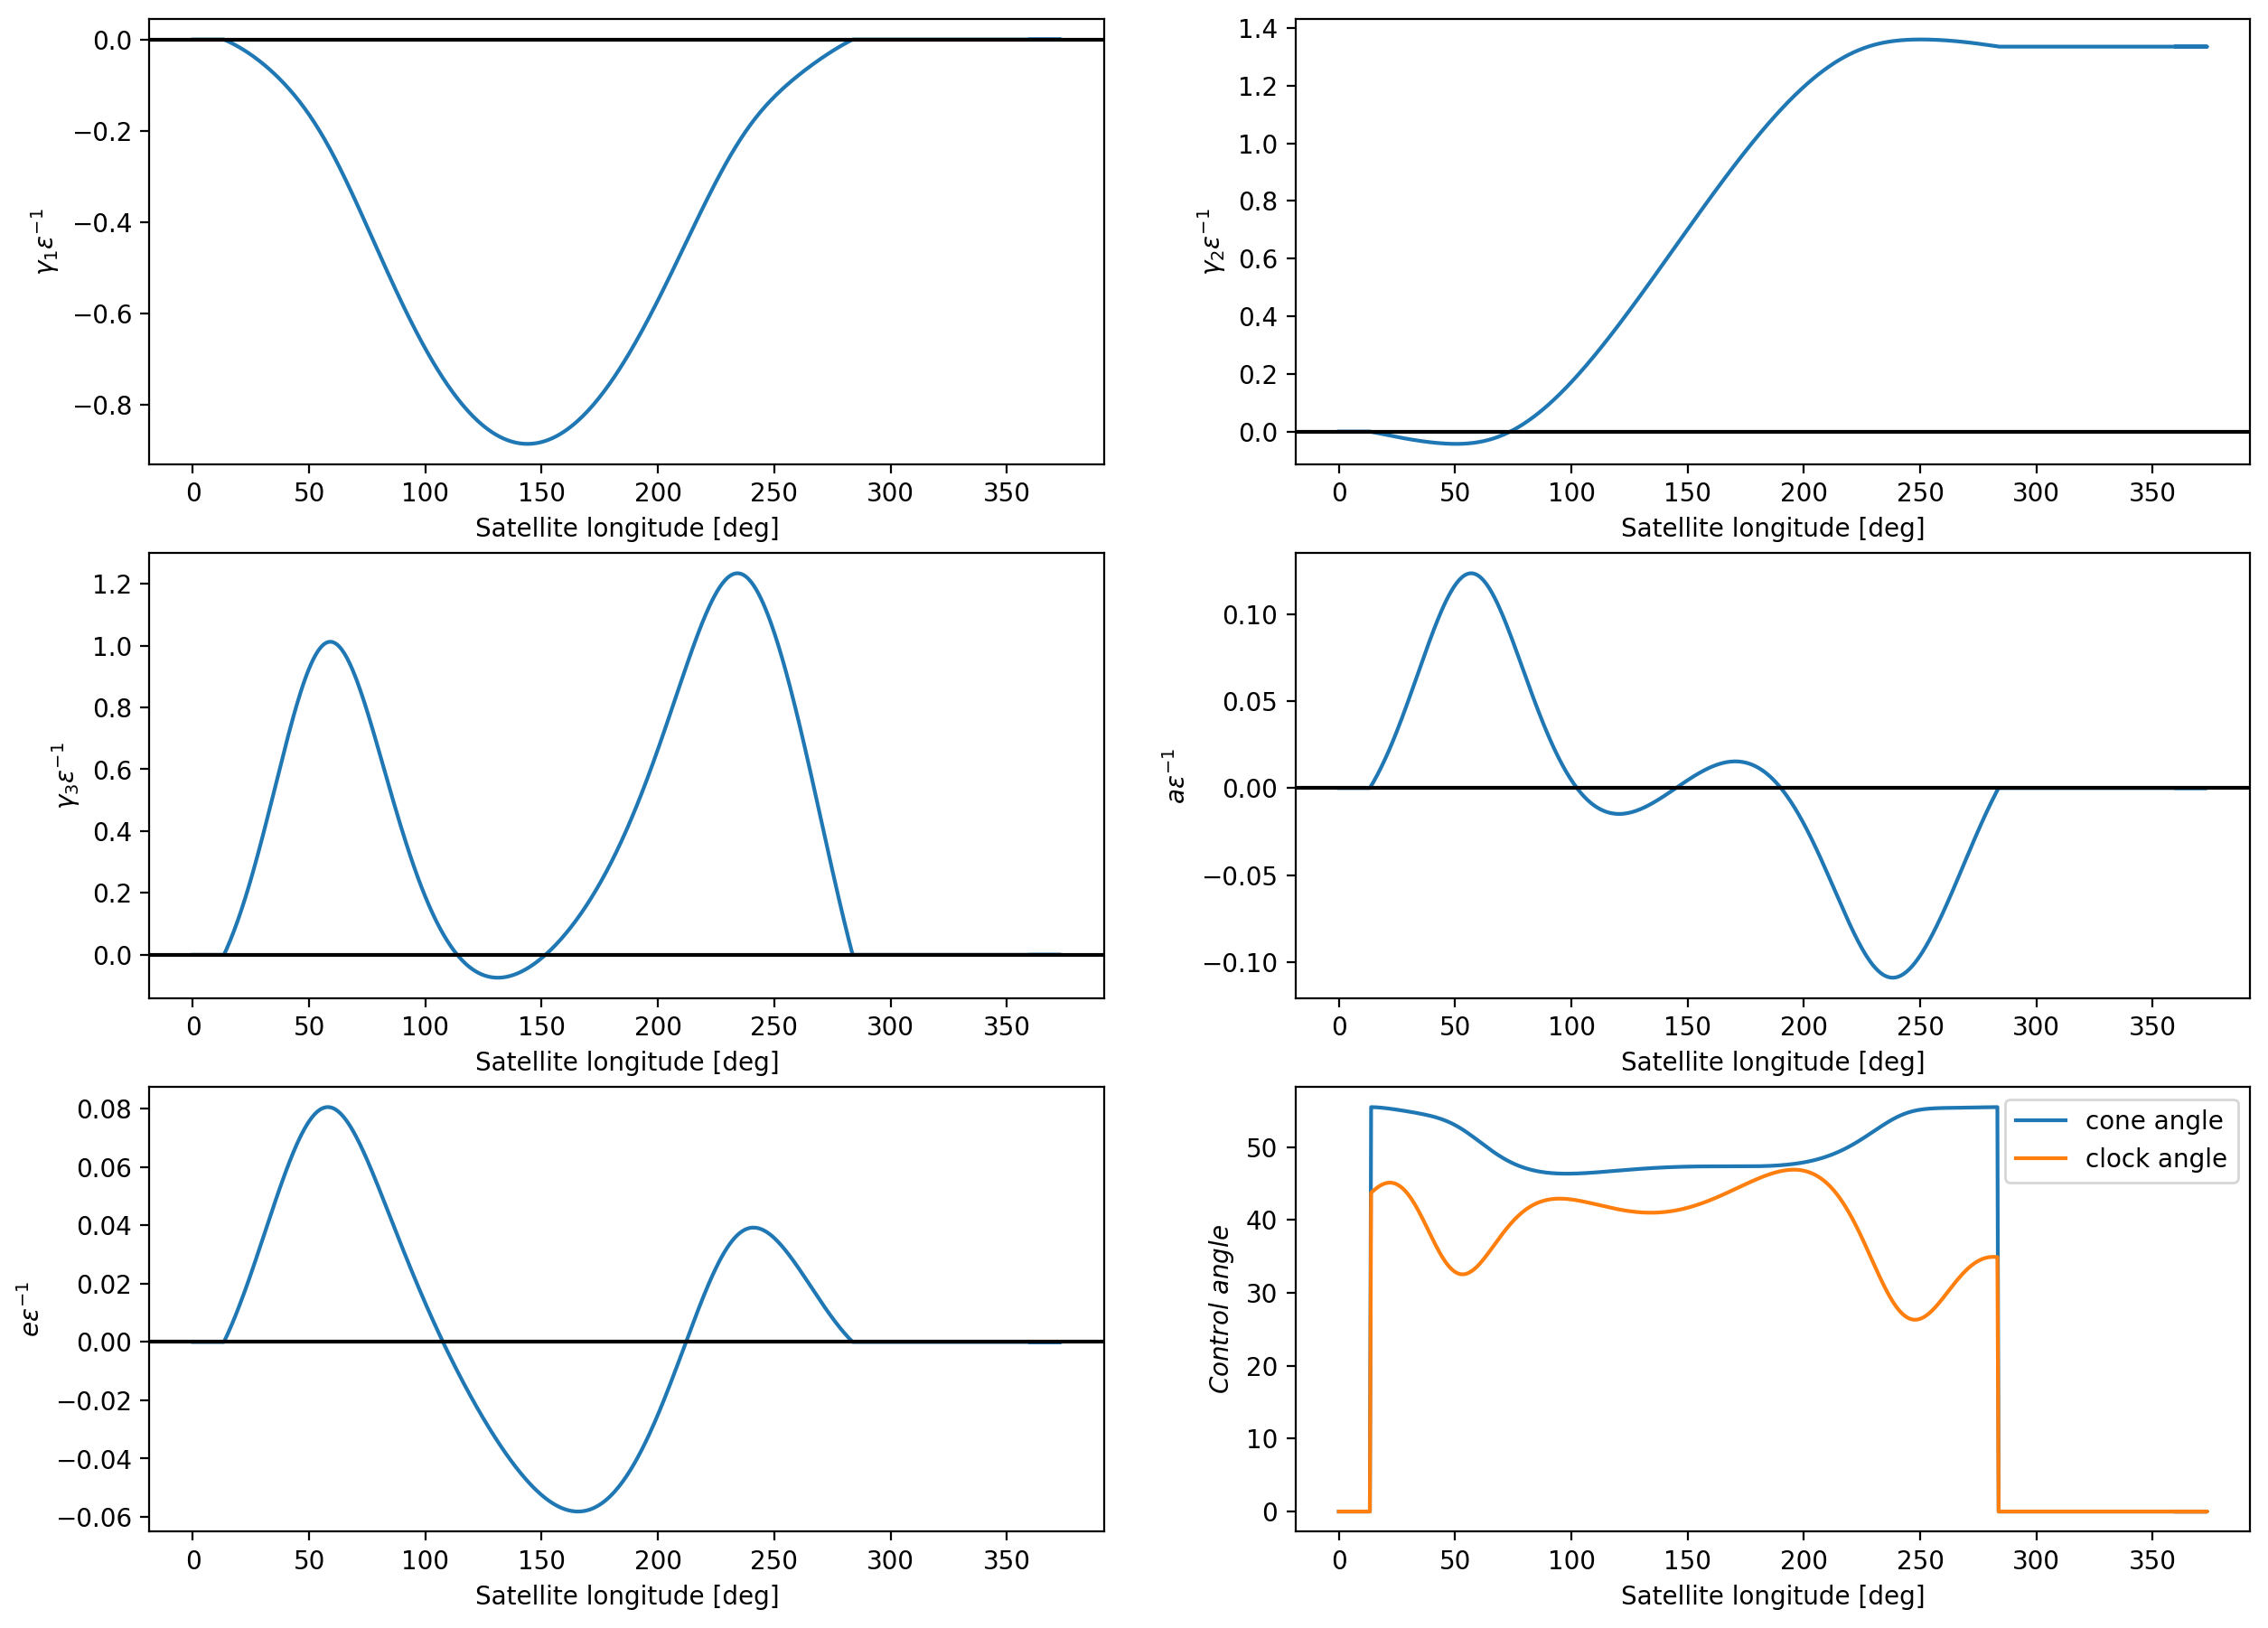

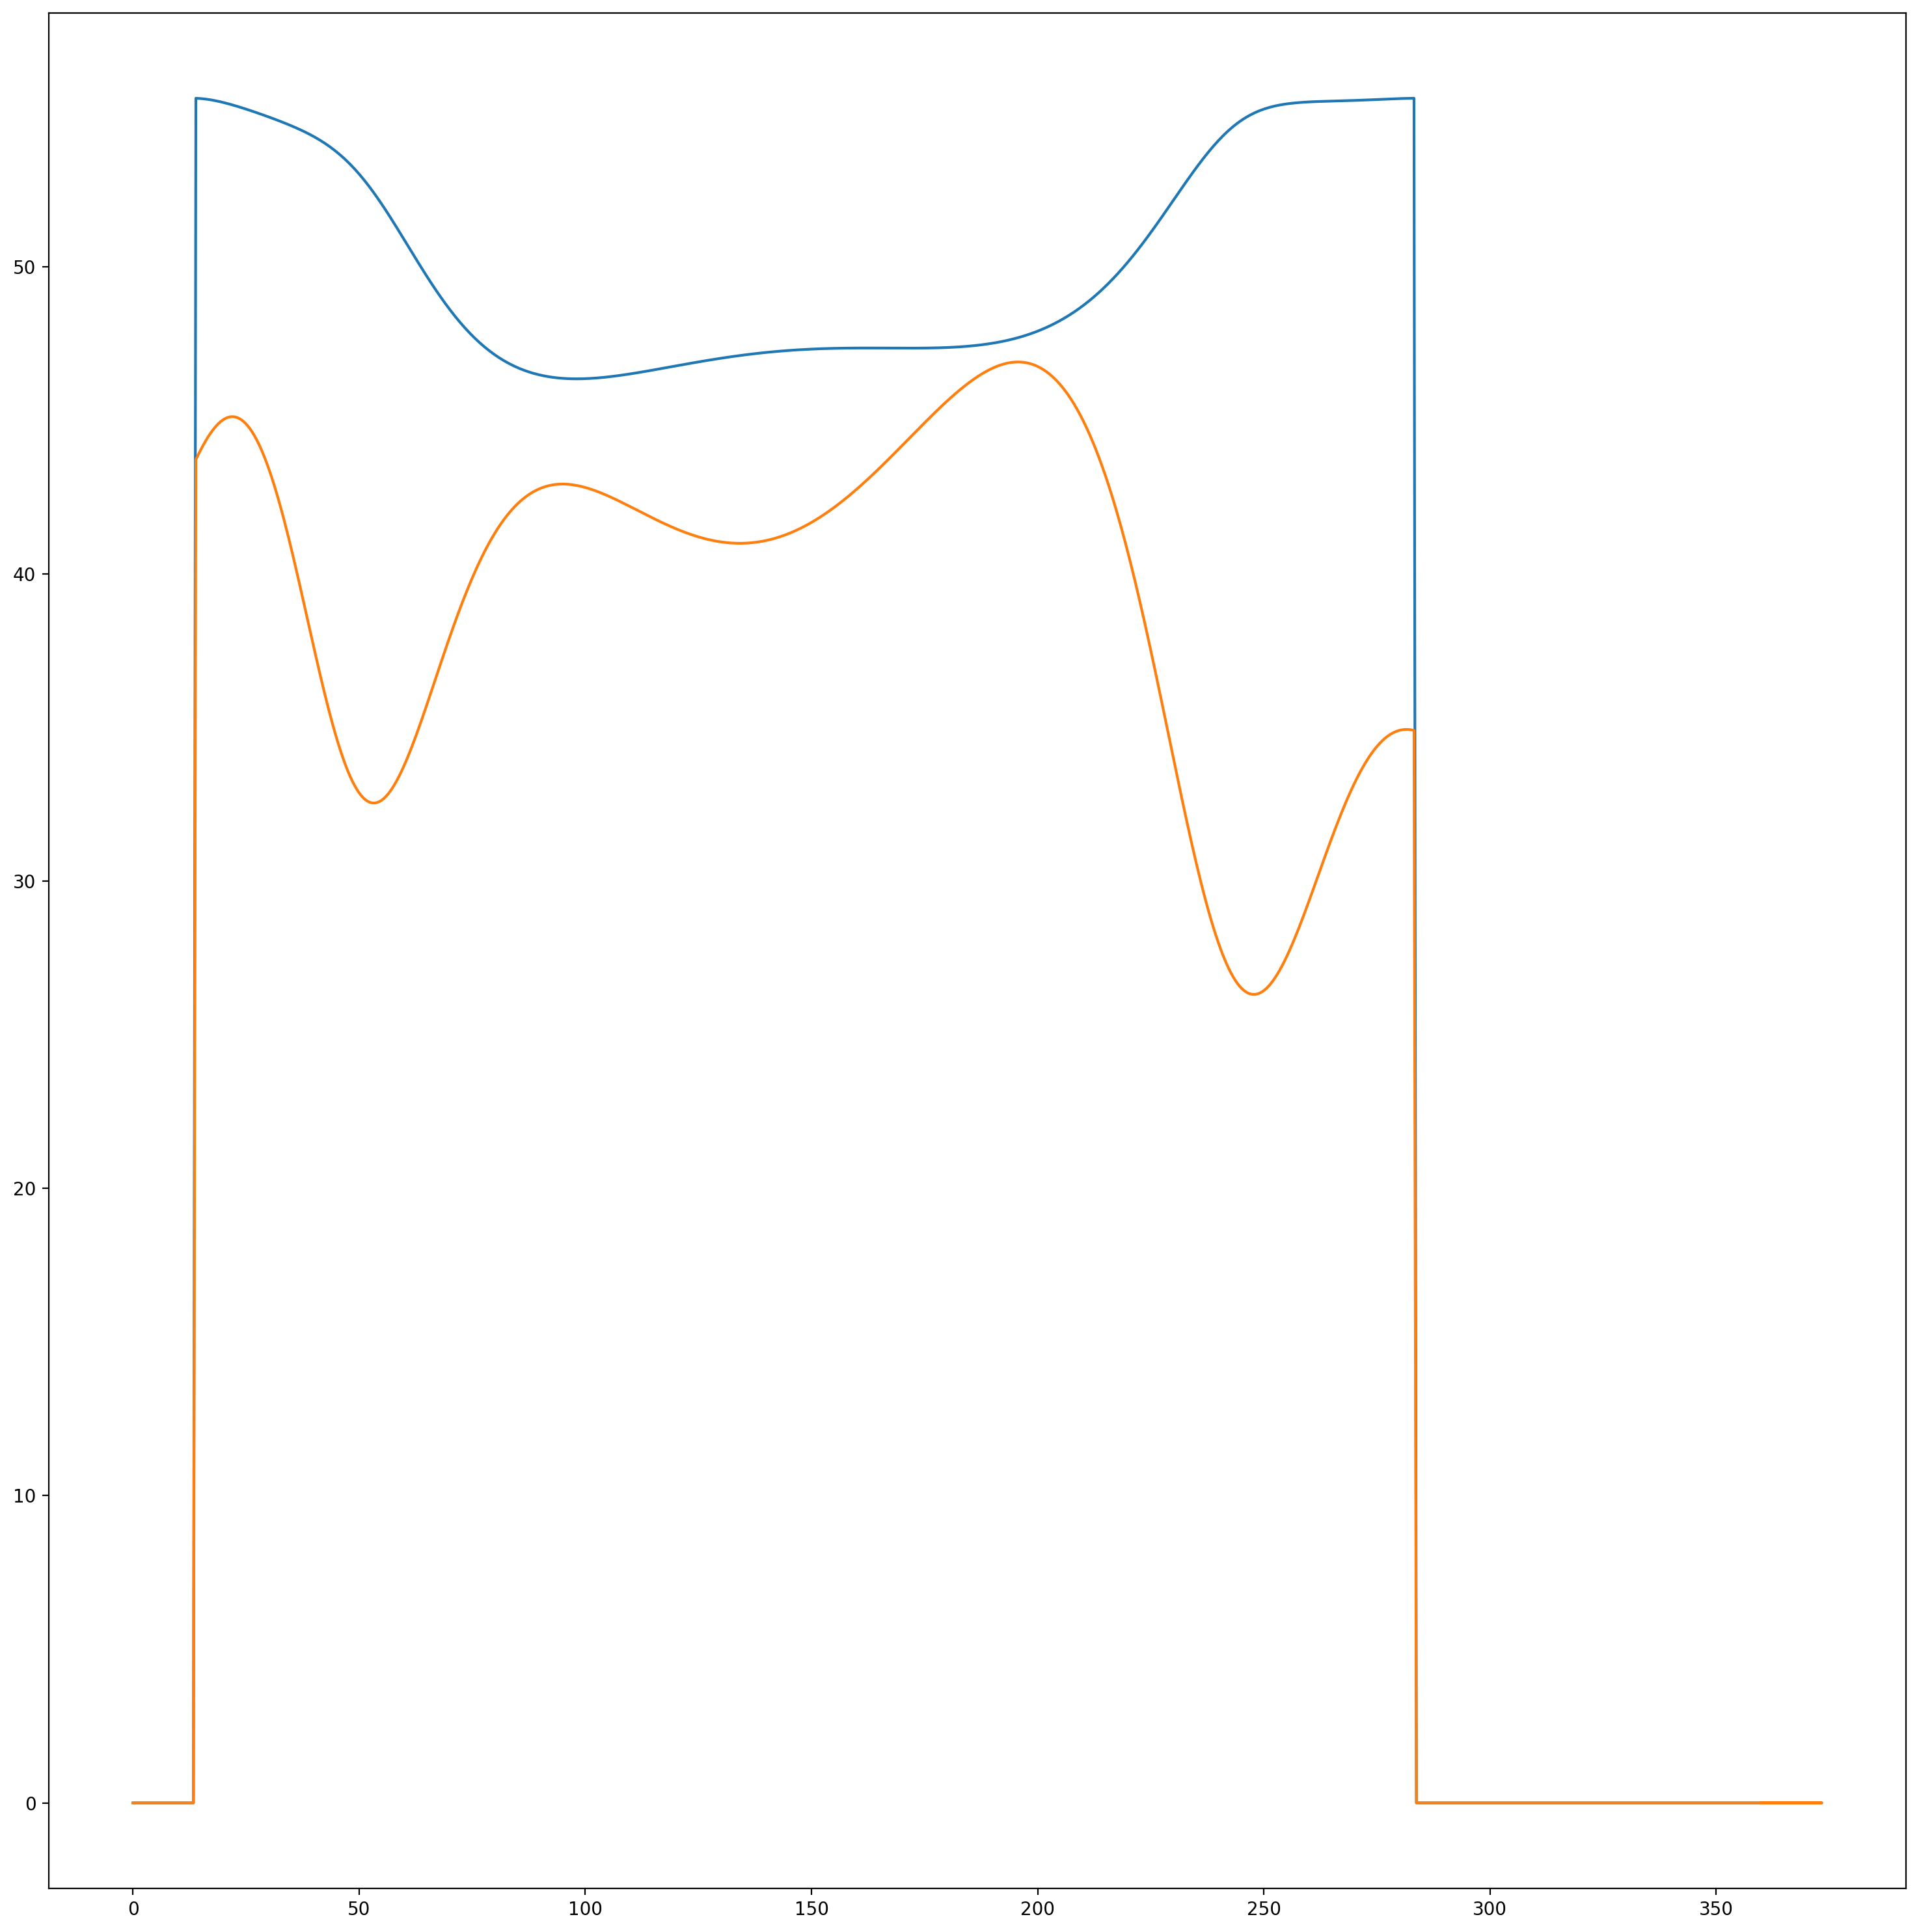

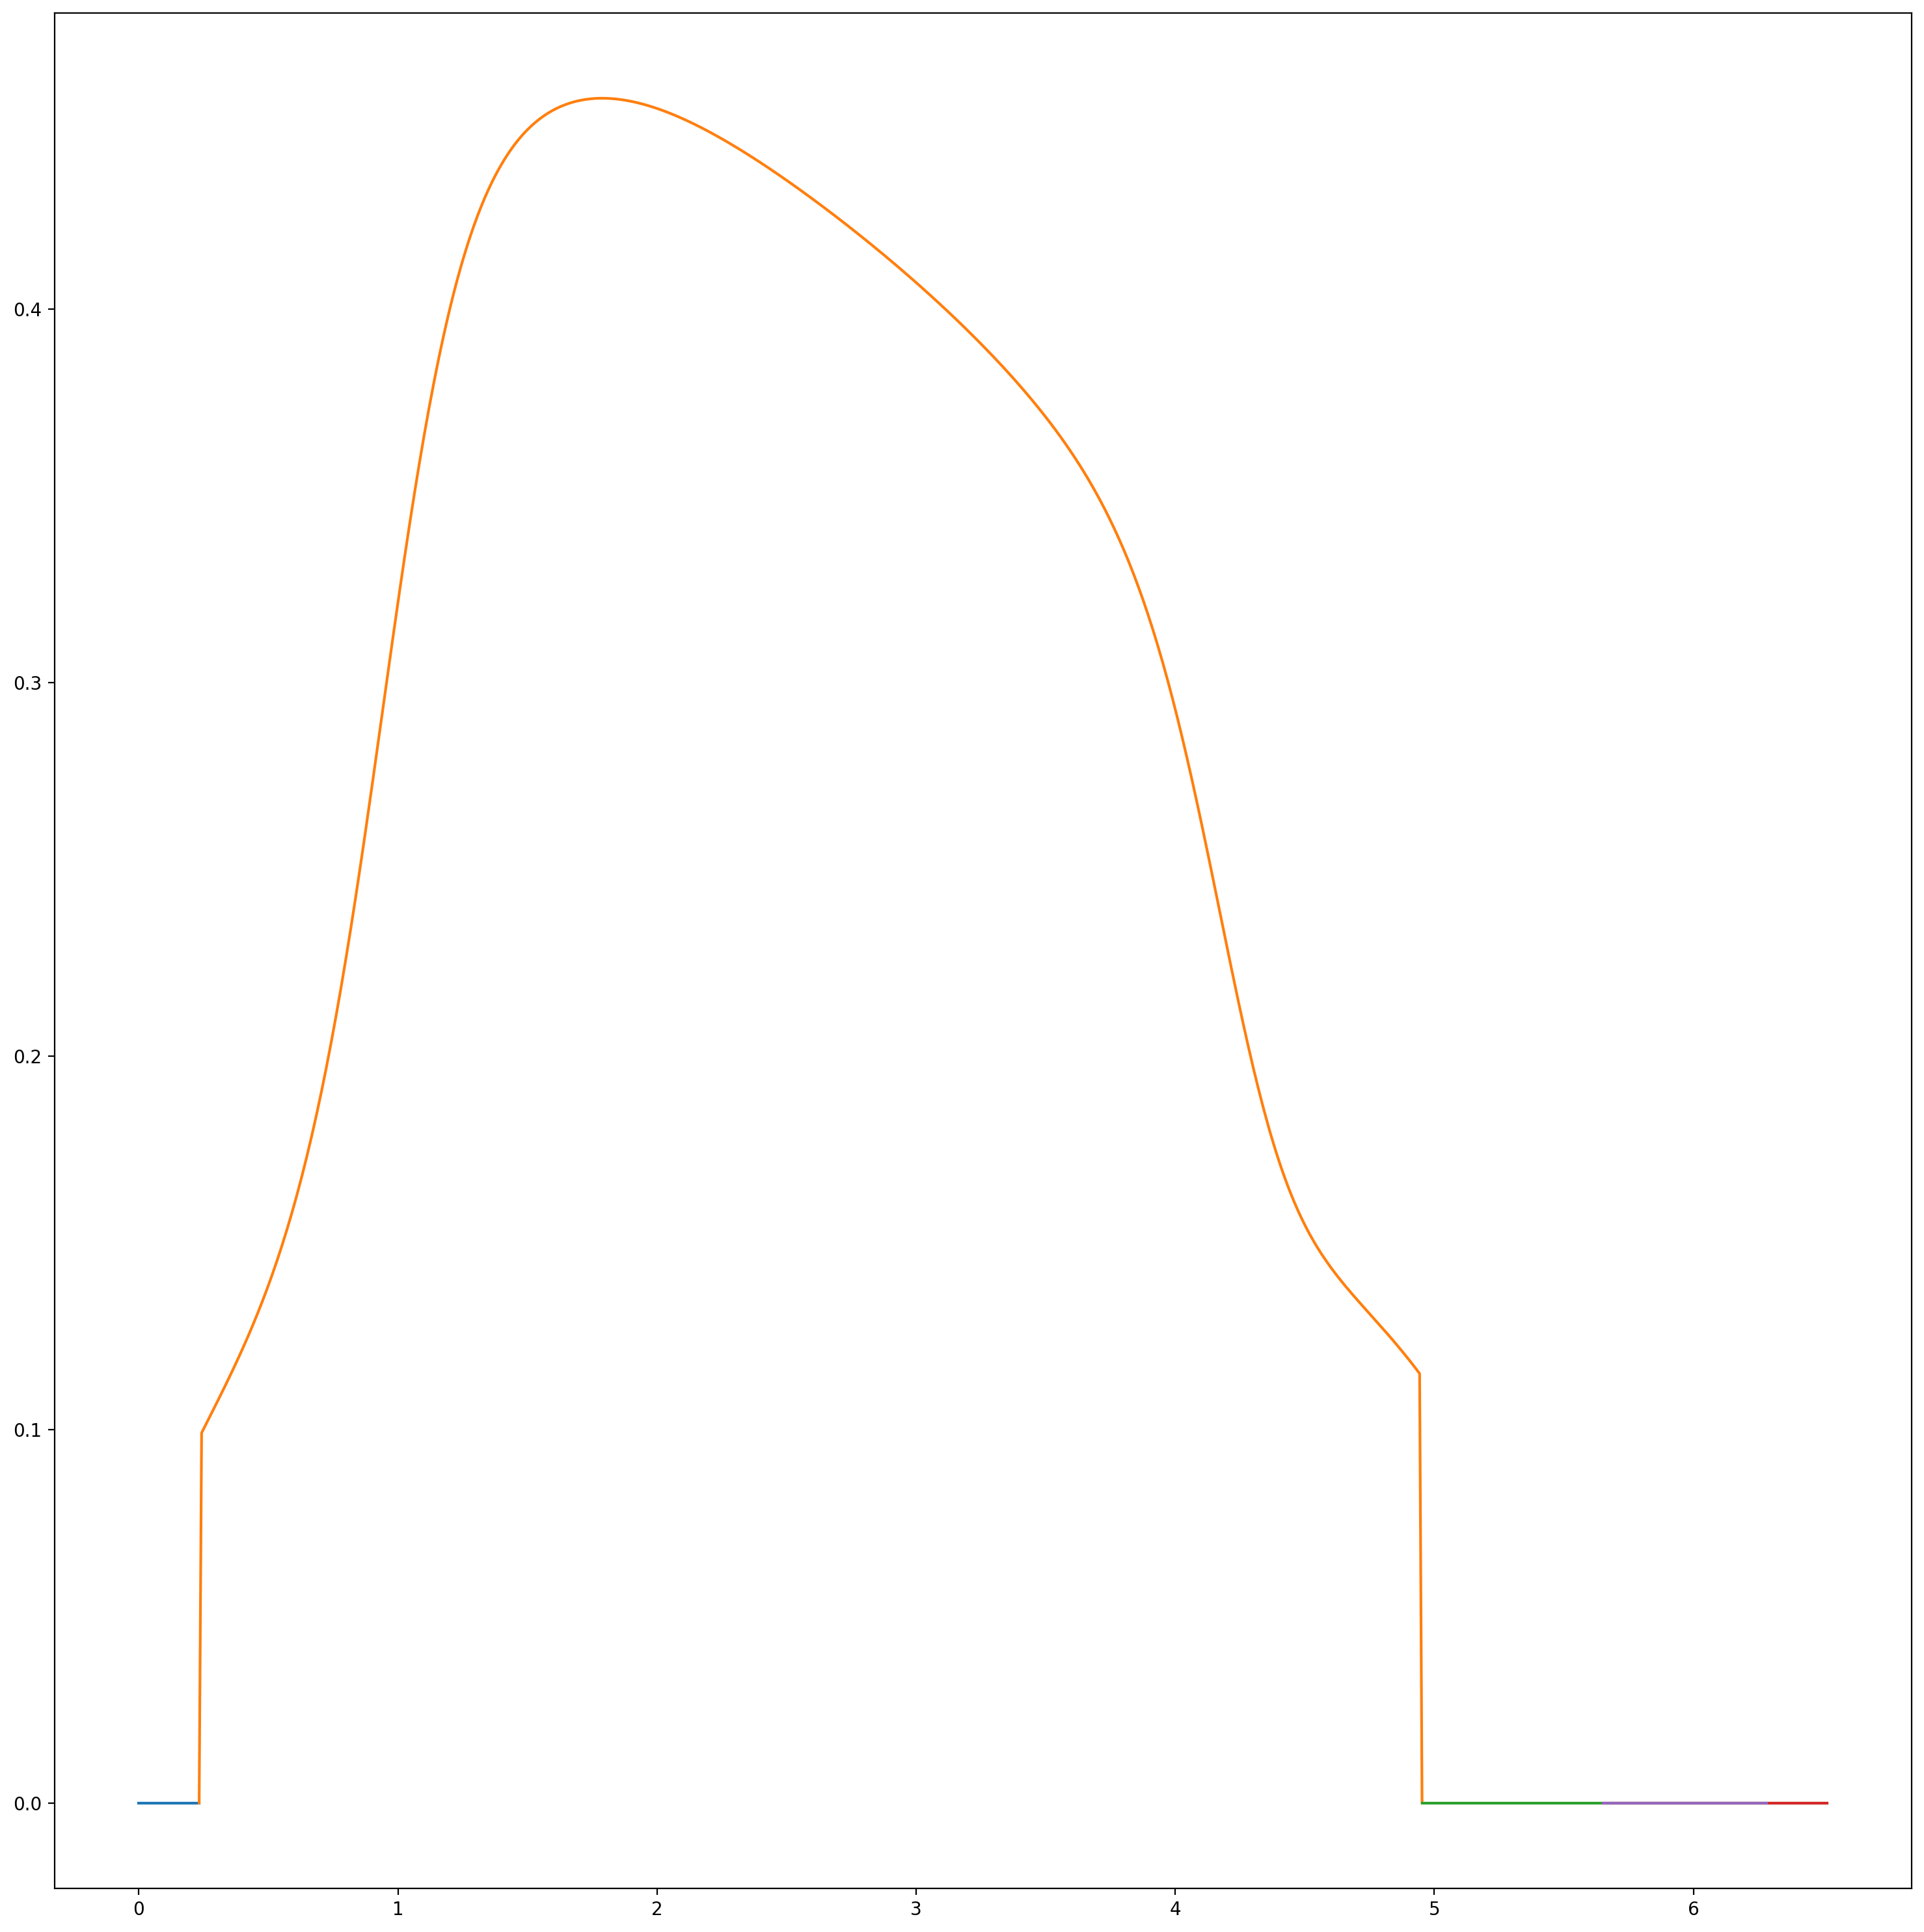

In [13]:
plotSolutionBSB(z_sol, sDir, cont, 1)
#plotSolutionBSB(pI, M1, M2, M3, M4, Mf, sDir, cont, 1)

## Function of continuous integration

## Homotopic function

## POST PROCESSING SHOOT 

# Integration of trajectory by injecting the control